# Double Q-learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class Environment:
    def __init__(self):
        self.state = None
        self.actions = [+1] + [-1] * 10
        self.num_action = len(self.actions)

    def reset(self):
        # Total states are [0, 1, 2, 3]
        self.state = 2
        return self.state

    def is_terminated(self):
        return self.state in [0, 3]

    def step(self, action):
        if self.is_terminated():
            return self.state, 0, True
            
        self.state += self.actions[action]
        if self.state != 0:
            reward = 0
        else:
            reward = np.random.normal(loc=-0.1, scale=1)

        return self.state, reward, self.is_terminated()

## Q-Learning

In [7]:
def Q_learning(Q_init:np.array,
               env:Environment,
               episodes:int=300,
               alpha:float=0.1,
               epsilon:float=0.1,
               gamma:float=1.0,
               runs:int=1):
    actions_taken = np.zeros(shape=(episodes, 2))
    for run in range(runs):
        Q = Q_init.copy()
        for episode in range(episodes):
            env.reset()
            state = env.state
            while not env.is_terminated():
                if np.random.rand() < epsilon:
                    if state == 2:
                        action = np.random.choice(2)
                    else:
                        action = np.random.randint(1, Q.shape[-1])
                else:
                    if state == 1:
                        action = np.argmax(Q[state, 1:]) + 1 # Plus one is the offset
                    else:
                        action = np.argmax(Q[state, :2])
                        # This line is important for the plot to be just like the plot from SAB
                        if Q[2, 0] == Q[2, 1]:
                            action = np.random.choice([0, 1])

                if state == 2:
                    actions_taken[episode][action] += 1

                new_state, reward, terminated = env.step(action)

                if new_state == 2:
                    max_q = np.max(Q[new_state, :2])
                elif new_state ==1:
                    max_q = np.max(Q[new_state, 1:])
                else:
                    max_q = np.max(Q[new_state, :2])
                Q[state, action] = Q[state, action] + alpha * (reward + gamma * max_q - Q[state, action])

                #print(state, action, new_state)
                state = new_state
        if run % 100 == 0:
            print(f'\rRun: {run + 100:>6}', end='')
    return Q, actions_taken

In [8]:
env = Environment()
Q_init = np.zeros(shape=(4, env.num_action), dtype=np.float32)
Q, Q_actions_taken = Q_learning(Q_init, env, episodes=300, runs=10000)

Run:  10000

## Double Q-Learning

In [10]:
def double_Q_learning(Q_init:np.array,
               env:Environment,
               episodes:int=300,
               alpha:float=0.1,
               epsilon:float=0.1,
               gamma:float=1.0,
               runs:int=1):
    actions_taken = np.zeros(shape=(episodes, 2))
    num_actions = Q_init.shape[-1]
    for run in range(runs):
        Q1 = Q_init.copy()
        Q2 = Q_init.copy()
        for episode in range(episodes):
            env.reset()
            state = env.state
            while not env.is_terminated():
                if np.random.choice(2) == 0:
                    estimator = Q1
                    maximizer = Q2
                else:
                    estimator = Q2
                    maximizer = Q1
                    
                if np.random.rand() < epsilon:
                    if state == 2:
                        action = np.random.choice(2)
                    else:
                        action = np.random.randint(1, num_actions)
                else:
                    Q = (Q1 + Q2) / 2
                    if state == 1:
                        action = np.argmax(Q[state, 1:]) + 1 # Plus one is the offset
                    else:
                        action = np.argmax(Q[state, :2])
                        # This line is important for the plot to be just like the plot from SAB
                        if Q[2, 0] == Q[2, 1]:
                            action = np.random.choice([0, 1])

                if state == 2:
                    actions_taken[episode][action] += 1

                new_state, reward, terminated = env.step(action)

                if new_state == 2:
                    a_prime = np.argmax(maximizer[new_state, :2])
                elif new_state ==1:
                    a_prime = np.argmax(maximizer[new_state, 1:]) + 1 # this is for offset
                else:
                    a_prime = np.argmax(maximizer[new_state, :2])
                estimator[state, action] = estimator[state, action] + alpha * \
                                        (reward + gamma * estimator[new_state, a_prime] - estimator[state, action])

                state = new_state
        if run % 100 == 0:
            print(f'\rRun: {run + 100:>6}', end='')
    return Q1, Q2, actions_taken

In [11]:
env = Environment()
Q_init = np.zeros(shape=(4, env.num_action), dtype=np.float32)
Q1, Q2, double_Q_actions_taken = double_Q_learning(Q_init, env, episodes=300, runs=10000)

Run:  10000

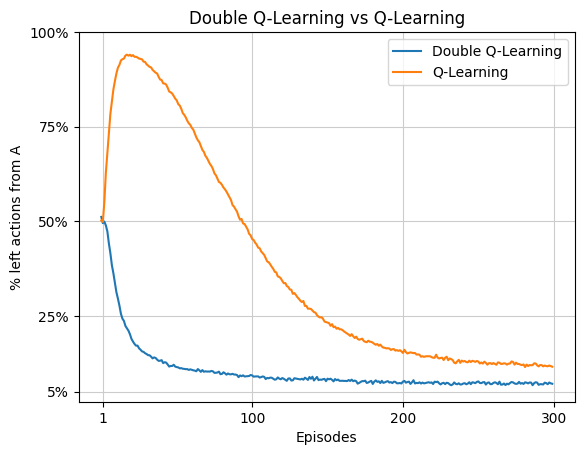

In [14]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(double_Q_actions_taken[:, 1] / 10000, label='Double Q-Learning')
ax.plot(Q_actions_taken[:, 1] / 10000, label='Q-Learning')
ax.grid(c='#ccc')
ax.legend()
ax.set_title('Double Q-Learning vs Q-Learning')
ax.set_xlabel('Episodes')
ax.set_ylabel('% left actions from A')
ax.set_xticks([1, 100, 200, 300])
ax.set_yticks([0.05, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(f'{int(x * 100)}%' for x in [0.05, 0.25, 0.5, 0.75, 1.0]);